Build a regression model.

In [3]:
#import libraries required
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [4]:
#load df into notebook
df = pd.read_csv('../data/final_miami_bikes_yelp.csv')
df.head()

,name,review_count,rating,price,distance,category_1,category_2,category_3,yelp_bike_station_coordinates,bikes
0,Asian Thai Kitchen,237,4.0,2,280.048258,Food Delivery Services,Thai,Thai,"25.729275,-80.241581",3
1,Loretta & The Butcher,224,4.5,3,343.398505,Argentine,Breakfast & Brunch,Breakfast & Brunch,"25.729275,-80.241581",3
2,Fireman Derek’s Bake Shop,254,4.5,2,257.370490,Desserts,Bakeries,Bakeries,"25.729275,-80.241581",3
3,Le Pain Quotidien,237,4.0,2,237.898851,Cafes,Bakeries,Bakeries,"25.729275,-80.241581",3
4,Salt and Straw,160,4.5,2,115.219169,Ice Cream & Frozen Yogurt,Desserts,Desserts,"25.729275,-80.241581",3


In [5]:
#Drop bike_station_coordinates column. 
#Will not be used in analysis, adds many duplicate rows that are unnecessary to building final model.
df_drop = df.drop(columns= ['yelp_bike_station_coordinates','category_1','category_2','category_3'], axis=1)

In [6]:
#Drop duplicate values
df_final = df_drop.drop_duplicates()

In [7]:
#Drop all null values (cannot be used in the analysis)
df_final = df_final.dropna(how='any',axis=0) 

In [8]:
#Verify that nf has no null values
df_final.isna().sum()

name            0
review_count    0
rating          0
price           0
distance        0
bikes           0
dtype: int64

In [9]:
df_final.shape
#df.shape

(3202, 6)

In [10]:
df_final.head()

,name,review_count,rating,price,distance,bikes
0,Asian Thai Kitchen,237,4.0,2,280.048258,3
1,Loretta & The Butcher,224,4.5,3,343.398505,3
2,Fireman Derek’s Bake Shop,254,4.5,2,257.370490,3
3,Le Pain Quotidien,237,4.0,2,237.898851,3
4,Salt and Straw,160,4.5,2,115.219169,3


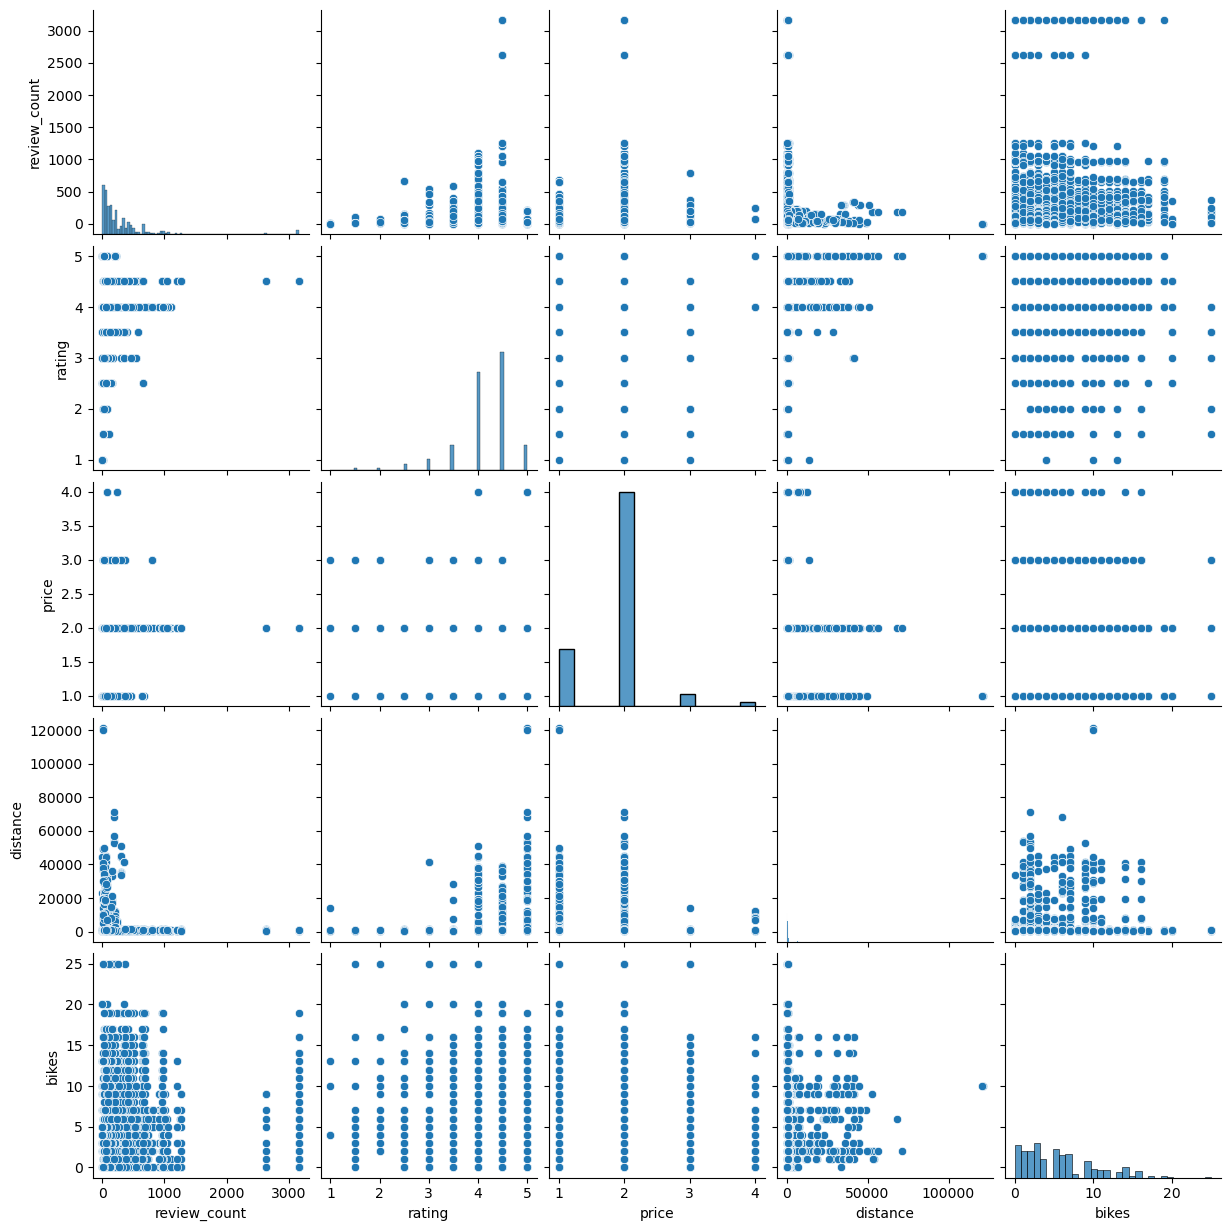

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(data=df_final)
plt.show()

No obvious colinearity or relationship between the variables. 
A few of the graphs are seen to be clustered. A few outliers noted. Will perform boxplots to find outliers. 

<Axes: xlabel='price', ylabel='bikes'>

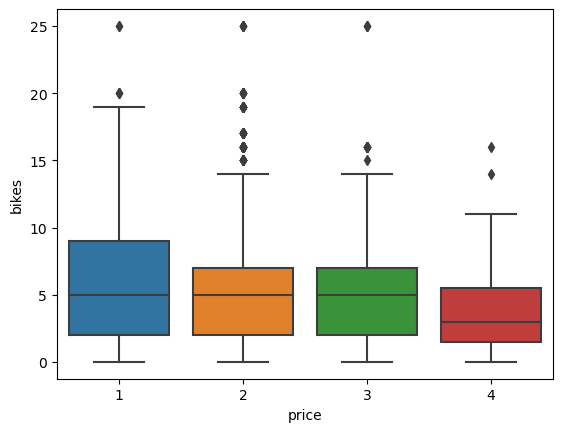

In [12]:
#find outliers to remove
sns.boxplot(x='price',y='bikes', data=df_final)

Few extreme outliers where bikes >=25 and price <4. 

In [13]:
#print outliers to pull rows
df_outliers = df_final.loc[(df_final['price'] <4)&(df_final['bikes']>= 25)]
print(df_outliers)

                     name  review_count  rating  price     distance  bikes
2434           Stripsteak           368     4.0      3   360.415159     25
2435         Chez Bon Bon           141     4.0      3   345.203416     25
2436          La Provence           155     3.5      2   971.878175     25
2437     Tasty Beach Cafe           204     3.5      2  1072.670433     25
2438  Primo Cafe & Market           245     3.5      1   965.760085     25
2439     Fresh Restaurant            23     3.0      2   321.976122     25
2440         CVS Pharmacy            22     3.0      2  1176.587804     25
2441            Walgreens            35     2.0      2   884.173242     25
2442              Dunkin'           101     1.5      1   909.090265     25
2443     Kastner's Market            19     2.0      3  1176.132057     25


<Axes: xlabel='rating', ylabel='bikes'>

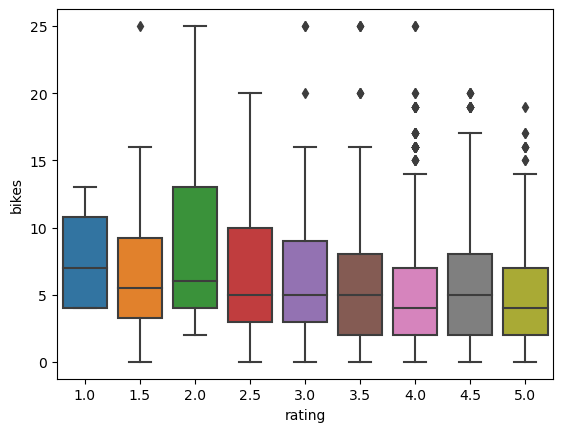

In [14]:
sns.boxplot(x='rating',y='bikes', data=df_final)

Extreme outlier Rating = 1.5, bike >=25

In [15]:
df_outliers_rating = df_final.loc[(df_final['rating']==1.5)&(df_final['bikes']>= 25)]
print(df_outliers_rating)
#this point can be removed, is an outliers in 2 featurees: rating and price

         name  review_count  rating  price    distance  bikes
2442  Dunkin'           101     1.5      1  909.090265     25


In [16]:
#remove outliers
df_final_outliers = df_final.drop(df_final[(df_final['price']<4) & (df_final['bikes'] >= 25)].index)
print(df_final.shape)
print(df_final_outliers.shape)

#check to see if outliers were removed

(3202, 6)
(3192, 6)


In [17]:
#Finding the correlation 
df_final_outliers.corr(numeric_only = True)

,review_count,rating,price,distance,bikes
review_count,1.000000,0.082040,0.045743,-0.104179,-0.016011
rating,0.082040,1.000000,0.067954,0.158287,-0.052232
price,0.045743,0.067954,1.000000,-0.091820,-0.069046
distance,-0.104179,0.158287,-0.091820,1.000000,-0.007858
bikes,-0.016011,-0.052232,-0.069046,-0.007858,1.000000


No strong correlation with y variable 'bikes'

In [18]:
#Check if the correlations are significant using Pearson's correlation coefficient test

import scipy

stat, p1 = scipy.stats.pearsonr(df_final_outliers['review_count'], df_final_outliers['bikes'])
stat, p2 = scipy.stats.pearsonr(df_final_outliers['rating'], df_final_outliers['bikes'])
stat, p3 = scipy.stats.pearsonr(df_final_outliers['price'], df_final_outliers['bikes'])
stat, p4 = scipy.stats.pearsonr(df_final_outliers['distance'], df_final_outliers['bikes'])


print(p1, p2, p3, p4)

0.36584160685704276 0.0031585246947965786 9.457836194387499e-05 0.657180240026235


Statistically significant correlation seen between between 'price' and 'bikes' with a p value of 457836194387499e-05. Rating is also significant with p value of 0031585246947965786 

In [19]:
#Performing model using 1 variable to start
#choosing df['Rating'] as the x variable as it seems to have the highest correlation 

y = df_final_outliers['bikes']
x = df_final_outliers['price']
#x = sm.add_constant(x) 
#constant was removed because it reduced the R_squared value by a significant amount.
x.head()  #view both x and y

0    2
1    3
2    2
3    2
4    2
Name: price, dtype: int64

In [20]:
#Create the model using x and y 

model = sm.OLS(y,x)
results = model.fit()  #fit the model 

Provide model output and an interpretation of the results. 

In [21]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  bikes   R-squared (uncentered):                   0.532
Model:                            OLS   Adj. R-squared (uncentered):              0.532
Method:                 Least Squares   F-statistic:                              3635.
Date:                Sun, 03 Sep 2023   Prob (F-statistic):                        0.00
Time:                        12:57:03   Log-Likelihood:                         -9576.5
No. Observations:                3192   AIC:                                  1.916e+04
Df Residuals:                    3191   BIC:                                  1.916e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The output using 1 independent variable, rating, was seen to have a strong R-squared of 0.532 meaning that 53.2% variance in bikes could be explained by the regression model. 
Additionally, the p value for 'price' was seen to be significant with a p value of 0.000. 

In [22]:
#To test for normality
#create residual plots
residuals = results.resid
residuals

0      -2.335708
1      -5.003563
2      -2.335708
3      -2.335708
4      -2.335708
          ...   
3197   -3.335708
3198   -0.667854
3199   -0.667854
3200   -3.335708
3201   -3.335708
Length: 3192, dtype: float64

The majority of the residual points are negative values meaning that the predicted value is higher than the expected

<Axes: ylabel='Count'>

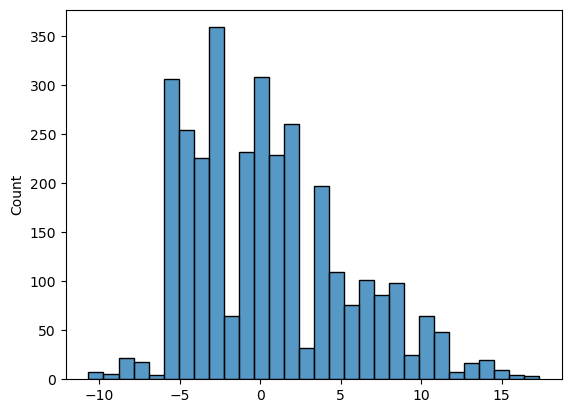

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

#visualize residuals as a histogram
sns.histplot(residuals)

Large portion of predicted data are higher than the expected value. 
A subset of the data is skewed to the right where the predicted value is lower than the expected value. Residual range is quite large from -11 to 17. 

<Axes: xlabel='price', ylabel='bikes'>

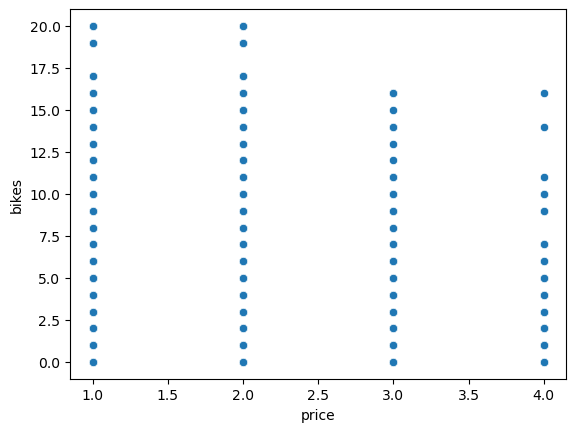

In [24]:
#visualize the data as a scatterplot
sns.scatterplot(data=df_final_outliers, x= 'price', y='bikes')

Slight decrease in number of bikes the higher the price is. No obvious correlation inferred. 

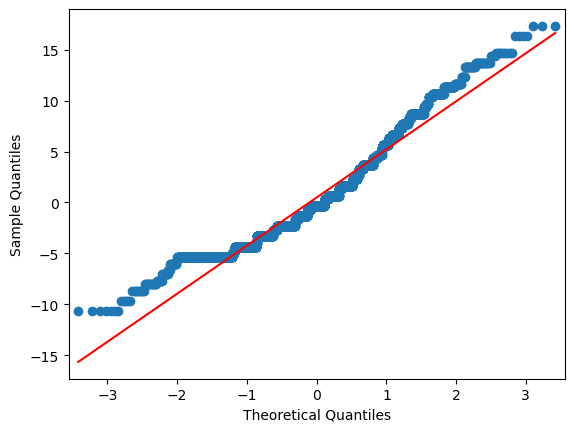

In [25]:
#To see if bikes and rating come from a population with the same distribution.
sm.qqplot(residuals, line='r')
plt.show()

Looking at the qq plot, the points are somewhat aligned to a few areas on the reference line. The 2 tail ends of the plot do not seem to match. Does not indicate the data follows a normal distribution. 

In [26]:
scipy.stats.shapiro(residuals)

ShapiroResult(statistic=0.9483112096786499, pvalue=4.017996031859238e-32)

As the p value is below 0.05, this means that the Shapiro test highly suggest that the data is not normally distributed

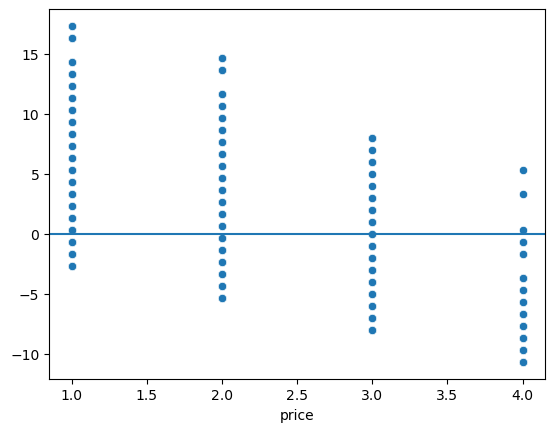

In [27]:
#homoscedasticity tests visual representation using scatterplot

ax= sns.scatterplot(x=df_final['price'], y= residuals)
ax.axhline(0)  #create a horizontal line at 0

Residuals not an equal distance away. Does not demonstrate a normal distribution

Adding more independent variables to the model to make a multiregression model. 

In [28]:
#Multilinear regression model 
#Set x and y variables for model
y = np.log(df_final_outliers['bikes']+1)   #normalized data by taking log of y. Cannot take log 0.Add +1
x = df_final_outliers[['price',
            'rating']]
#x = sm.add_constant(x) #removed constant as it decreased the R_squared value
x.head()  

,price,rating
0,2,4.0
1,3,4.5
2,2,4.5
3,2,4.0
4,2,4.5


In [29]:
model = sm.OLS(y,x)
results = model.fit()  #fit the model 
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  bikes   R-squared (uncentered):                   0.769
Model:                            OLS   Adj. R-squared (uncentered):              0.769
Method:                 Least Squares   F-statistic:                              5304.
Date:                Sun, 03 Sep 2023   Prob (F-statistic):                        0.00
Time:                        12:57:06   Log-Likelihood:                         -4035.1
No. Observations:                3192   AIC:                                      8074.
Df Residuals:                    3190   BIC:                                      8086.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Compared to the previous model summary, the multiregression model have a stronger R-squared value. Model improved with normalizing and adding another x variable. 

In [30]:
#To test for normality of the multiregression model
#create residual plots
residuals = results.resid
residuals

0      -0.127168
1      -0.393949
2      -0.290485
3      -0.127168
4      -0.290485
          ...   
3197   -0.578167
3198   -0.474703
3199   -0.474703
3200   -0.741484
3201   -0.414850
Length: 3192, dtype: float64

Residuals are negative but are less than previously calculated. 

<Axes: ylabel='Count'>

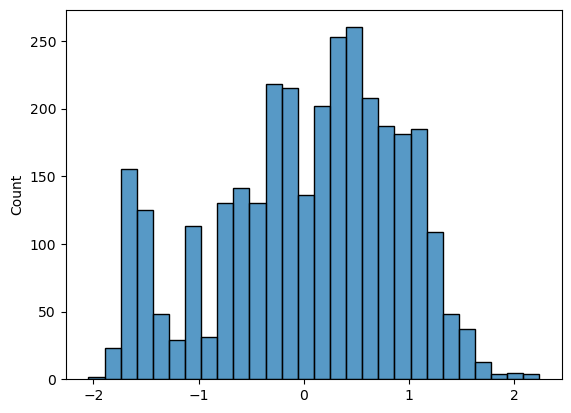

In [31]:
#visualize residuals as a histogram
sns.histplot(residuals)

The residuals are seen to be more normally distributed compared to using 1 variable to create the model. Range is much smaller

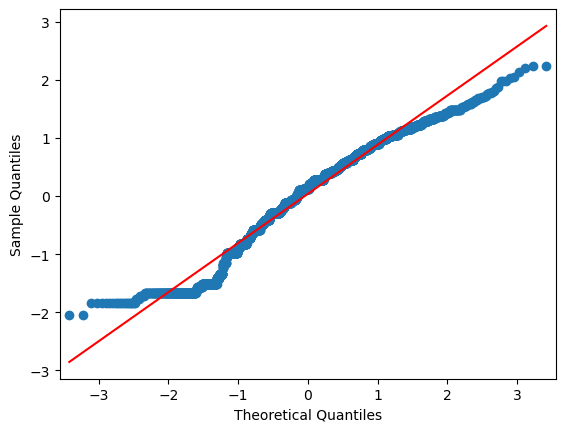

In [32]:
#To see if variables are within the same population 
sm.qqplot(residuals, line='r')
plt.show()

qq plot fits the line better with slight deviations. Does not seem normally distributed

In [33]:
#Formal test for homoscediscity 
scipy.stats.shapiro(residuals)

ShapiroResult(statistic=0.9693858623504639, pvalue=1.4569602713614294e-25)


Shapiro p value is significantly below 0.05. Suggests that the data is not drawn from a normal distribution. 

In [34]:
#bresuch test for homoscdiscity

stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals, results.model.exog)
print(p)

1.263428007783398e-278


From the bresuchpagan test we can say that the model is not normally distributed. 

In [35]:
#Create the model predictor here:
m_lst = results.params[['price',
                'rating']]
print(m_lst)

price     0.103464
rating    0.326634
dtype: float64


In [36]:
import math
#Test cases using model predictor
x_lst = [2,4]

predictions = [m*x for m,x in zip(m_lst,x_lst)]
sum_predictions = sum(predictions)

predicted_value= np.exp(sum_predictions) -1
print(predicted_value)

3.542432816113096


model predicted=3, actual = 3

In [53]:
new_X = pd.DataFrame({'X1': np.linspace(start=0,stop=10.0,num=10), # price
                      'X2': np.linspace(start=0,stop=5,num=10), # rating
                              })
predictions = results.predict(new_X, transform = True)

0    0.000000
1    0.296423
2    0.592846
3    0.889270
4    1.185693
5    1.482116
6    1.778539
7    2.074962
8    2.371385
9    2.667809
dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
5    1.0
6    1.0
7    2.0
8    2.0
9    2.0
dtype: float64


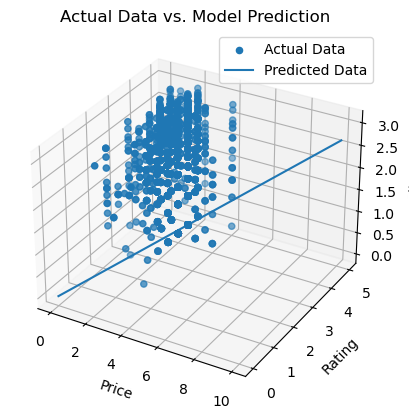

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')

# Plot the scatter plot
ax.scatter(x['price'], x['rating'], y, label='Actual Data')
ax.plot(new_X['X1'], new_X['X2'], predictions, label='Predicted Data')

ax.set_xlabel('Price')
ax.set_ylabel('Rating')
ax.set_zlabel('Bikes')
ax.legend()
ax.set_title('Actual Data vs. Model Prediction')

plt.show()
# plt.scatter(X[], y, label ='Actual Data')

Data seems to be clustered. Does not match a linear regression.May need to use another kind of graph to better demonstrate the data. 

# Stretch

How can you turn the regression model into a classification model?

In order to turn this regrsesion model into a classification, the response variable (bikes) must be made into a categorical variable. This would be done by binning the "bikes" into intervals and then labelling the intervals with markers that represent each bin. Depending on how many bins are required they can be named arbitrarily starting from 1. If there are not many categories these numbers can be further divided into "low traffic, medium traffic, high traffic" areas. 

After converting the response variable, bikes, to a categorical variable we woud have to change the model. Since the response variable is categorical, we would use a logistic regression to better represent the data.